In [40]:
"""
============================================================================
PHASE 3: UNSUPERVISED LEARNING - CLUSTERING ANALYSIS
============================================================================
Objective: Apply clustering to discover hidden patterns in football match data
and integrate insights with the supervised prediction model from Phase 2.

Author: [Your Name]
Date: November 2024
============================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [41]:
import pickle

with open("supervised_results.pkl", "rb") as f:
    results = pickle.load(f)

X_test = results["X_test"]
y_home_test = results["y_home_test"]
y_away_test = results["y_away_test"]
y_home_pred_rounded = results["y_home_pred_rounded"]
y_away_pred_rounded = results["y_away_pred_rounded"]


In [42]:
"""
============================================================================
BLOCK 1: LOAD PRE-PROCESSED DATA FROM PHASE 2
============================================================================
"""

print("="*80)
print("LOADING DATA FROM PHASE 2")
print("="*80)

import os

possible_paths = [
    'Dataset/SPL_raw_normalized.csv',
    'SPL_raw_normalized.csv',
    '../Dataset/SPL_raw_normalized.csv'
]

df = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ Loading data from: {path}")
        df = pd.read_csv(path)
        break

if df is None:
    raise FileNotFoundError("Dataset not found! Please check the file path.")

df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df = df.dropna(subset=['home_score', 'away_score'])
df['home_score'] = df['home_score'].astype(int)
df['away_score'] = df['away_score'].astype(int)
df = df.sort_values('date').reset_index(drop=True)

print(f"Dataset loaded: {df.shape[0]} matches, {df.shape[1]} features")


LOADING DATA FROM PHASE 2
✓ Loading data from: ../Dataset/SPL_raw_normalized.csv
Dataset loaded: 3257 matches, 17 features


In [43]:
"""
============================================================================
BLOCK 2: FEATURE ENGINEERING FOR CLUSTERING
============================================================================
"""

print("\n" + "="*80)
print("FEATURE ENGINEERING FOR CLUSTERING")
print("="*80)

def calculate_team_stats(df):
    """Calculate team performance statistics"""
    team_stats = {}
    all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
    
    for team in all_teams:
        home_matches = df[df['home_team'] == team]
        away_matches = df[df['away_team'] == team]
        total_matches = len(home_matches) + len(away_matches)
        
        if total_matches > 0:
            goals_scored = home_matches['home_score'].sum() + away_matches['away_score'].sum()
            goals_conceded = home_matches['away_score'].sum() + away_matches['home_score'].sum()
            
            home_wins = len(home_matches[home_matches['home_score'] > home_matches['away_score']])
            away_wins = len(away_matches[away_matches['away_score'] > away_matches['home_score']])
            draws_home = len(home_matches[home_matches['home_score'] == home_matches['away_score']])
            draws_away = len(away_matches[away_matches['away_score'] == away_matches['home_score']])
            
            team_stats[team] = {
                'attack': goals_scored / total_matches,
                'defense': goals_conceded / total_matches,
                'win_rate': (home_wins + away_wins) / total_matches,
                'draw_rate': (draws_home + draws_away) / total_matches,
                'home_advantage': home_wins / len(home_matches) if len(home_matches) > 0 else 0,
                'matches': total_matches
            }
    
    return team_stats


team_stats = calculate_team_stats(df)

df['Home_Attack'] = df['home_team'].map(lambda x: team_stats.get(x, {}).get('attack', 0))
df['Home_Defense'] = df['home_team'].map(lambda x: team_stats.get(x, {}).get('defense', 0))
df['Away_Attack'] = df['away_team'].map(lambda x: team_stats.get(x, {}).get('attack', 0))
df['Away_Defense'] = df['away_team'].map(lambda x: team_stats.get(x, {}).get('defense', 0))
df['Home_Win_Rate'] = df['home_team'].map(lambda x: team_stats.get(x, {}).get('win_rate', 0))
df['Away_Win_Rate'] = df['away_team'].map(lambda x: team_stats.get(x, {}).get('win_rate', 0))

df['Total_Goals'] = df['home_score'] + df['away_score']
df['Goal_Difference'] = df['home_score'] - df['away_score']
df['Attack_Difference'] = df['Home_Attack'] - df['Away_Attack']
df['Defense_Difference'] = df['Home_Defense'] - df['Away_Defense']
df['Win_Rate_Difference'] = df['Home_Win_Rate'] - df['Away_Win_Rate']


FEATURE ENGINEERING FOR CLUSTERING


In [44]:
"""
============================================================================
BLOCK 3: PREPARE DATA FOR CLUSTERING
============================================================================
"""

print("\n" + "="*80)
print("PREPARING DATA FOR CLUSTERING")
print("="*80)

clustering_features = [
    'Home_Attack', 'Home_Defense', 'Away_Attack', 'Away_Defense',
    'Home_Win_Rate', 'Away_Win_Rate', 'Total_Goals', 'Goal_Difference',
    'Attack_Difference', 'Defense_Difference', 'Win_Rate_Difference'
]

df_clean = df.dropna(subset=clustering_features).copy()
X_clustering = df_clean[clustering_features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)


PREPARING DATA FOR CLUSTERING


In [45]:
"""
============================================================================
BLOCK 4: DETERMINE OPTIMAL NUMBER OF CLUSTERS
============================================================================
"""

print("\n" + "="*80)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    print(f"k={k} → Silhouette={silhouette_score(X_scaled, labels):.3f}")

optimal_k = k_range[np.argmax(sil_scores)]
print(f"\n✓ Optimal k = {optimal_k}")


FINDING OPTIMAL NUMBER OF CLUSTERS
k=2 → Silhouette=0.320
k=3 → Silhouette=0.324
k=4 → Silhouette=0.326
k=5 → Silhouette=0.258
k=6 → Silhouette=0.239
k=7 → Silhouette=0.206
k=8 → Silhouette=0.197
k=9 → Silhouette=0.187
k=10 → Silhouette=0.190

✓ Optimal k = 4


In [46]:
"""
============================================================================
BLOCK 5: APPLY K-MEANS
============================================================================
"""

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans_final.fit_predict(X_scaled)

print("\nCluster Distribution:")
print(df_clean['Cluster'].value_counts().sort_index())



Cluster Distribution:
Cluster
0     446
1     845
2    1126
3     840
Name: count, dtype: int64


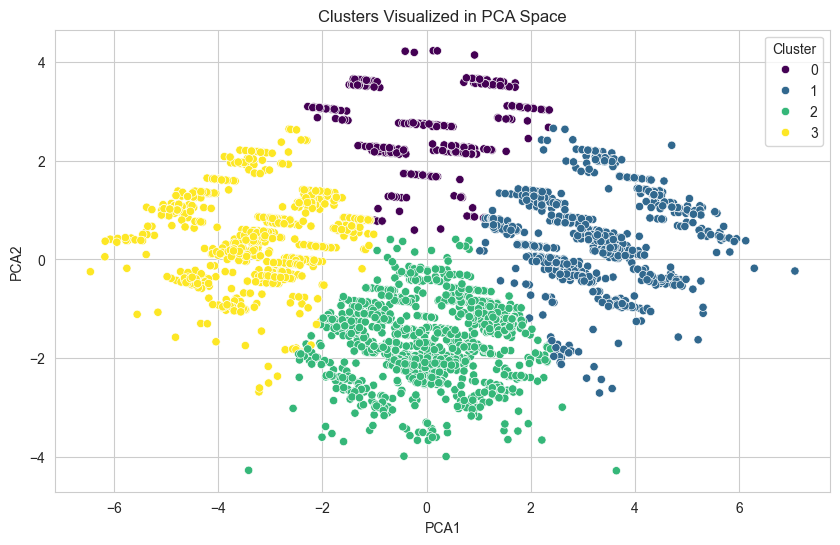

In [47]:
"""
============================================================================
BLOCK 6: PCA VISUALIZATION
============================================================================
"""

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_clean['PCA1'], 
    y=df_clean['PCA2'], 
    hue=df_clean['Cluster'], 
    palette='viridis'
)
plt.title("Clusters Visualized in PCA Space")
plt.show()

In [48]:
"""
============================================================================
BLOCK 7: ANALYZE CLUSTERS
============================================================================
"""

for cl in sorted(df_clean['Cluster'].unique()):
    data = df_clean[df_clean['Cluster'] == cl]
    print(f"\nCluster {cl}")
    print("-"*40)
    print(f"Matches: {len(data)}")
    print(f"Avg Total Goals: {data['Total_Goals'].mean():.2f}")
    print(f"Avg Goal Diff: {data['Goal_Difference'].mean():.2f}")



Cluster 0
----------------------------------------
Matches: 446
Avg Total Goals: 2.73
Avg Goal Diff: 0.11

Cluster 1
----------------------------------------
Matches: 845
Avg Total Goals: 3.16
Avg Goal Diff: 1.44

Cluster 2
----------------------------------------
Matches: 1126
Avg Total Goals: 2.75
Avg Goal Diff: 0.25

Cluster 3
----------------------------------------
Matches: 840
Avg Total Goals: 2.95
Avg Goal Diff: -0.96


In [ ]:
"""
============================================================================
BLOCK 8: INTEGRATION WITH SUPERVISED MODEL
============================================================================
"""

print("\n" + "="*80)
print("ADDING CLUSTER DISTANCE FEATURES")
print("="*80)

cluster_centers = kmeans_final.cluster_centers_

#  cluster
for i in range(optimal_k):
    df_clean[f"Dist_to_Cluster_{i}"] = np.linalg.norm(
        X_scaled - cluster_centers[i], axis=1
    )

print("✓ Cluster distance features added successfully!")


ADDING CLUSTER DISTANCE FEATURES
✓ Cluster distance features added successfully!


In [ ]:
"""
============================================================================
BLOCK 8.5: MERGE CLUSTER FEATURES BACK INTO FULL DATASET
============================================================================
"""

print("\n" + "="*80)
print("MERGING CLUSTER FEATURES INTO ORIGINAL DATASET")
print("="*80)

cluster_cols = ['Cluster'] + [f"Dist_to_Cluster_{i}" for i in range(optimal_k)]

df_merged = df.merge(
    df_clean[['date', 'home_team', 'away_team'] + cluster_cols],
    on=['date', 'home_team', 'away_team'],
    how='left'
)

print("✓ df_merged created successfully!")
print(df_merged.head())


MERGING CLUSTER FEATURES INTO ORIGINAL DATASET
✓ df_merged created successfully!
   match_id       date   time    home_team  away_team  home_score  away_score  \
0       1.0 2000-11-02  20:00   Al-Ettifaq  Al Riyadh           1           0   
1       2.0 2000-11-02  20:00     Al Najma   Al-Nassr           0           1   
2       3.0 2000-11-03  20:00   Al Ahli SC   Al Ansar           3           0   
3       4.0 2000-11-07  20:00  Al Qadisiya      Sdoos           0           3   
4       5.0 2000-11-08  20:00     Al Wehda  Al-Shabab           1           0   

  stadium city round  ... Total_Goals  Goal_Difference Attack_Difference  \
0     NaN  NaN   NaN  ...           1                1          0.167958   
1     NaN  NaN   NaN  ...           1               -1         -0.692979   
2     NaN  NaN   NaN  ...           3                3          0.833494   
3     NaN  NaN   NaN  ...           3               -3          0.448623   
4     NaN  NaN   NaN  ...           1              

In [ ]:
"""
============================================================================
BLOCK 8.6: EXPORT PHASE 3 CLEAN WITH CLUSTER FEATURES
============================================================================
"""

import os

dataset_dir = "../Dataset"
os.makedirs(dataset_dir, exist_ok=True)

output_file = os.path.join(dataset_dir, "phase3_clean_clusters.csv")

# ['date', 'home_team', 'away_team', ... , 'Cluster', 'Dist_to_Cluster_0', ...]
export_cols = ['date', 'home_team', 'away_team', 'Cluster'] + [f"Dist_to_Cluster_{i}" for i in range(optimal_k)]

df_clean[export_cols].to_csv(output_file, index=False)
print(f"✓ Phase 3 clean dataset with cluster features exported to '{output_file}'")


✓ Phase 3 clean dataset with cluster features exported to '../Dataset\phase3_clean_clusters.csv'
